In [1]:
#using Pkg
#Pkg.add(url="https://github.com/QEDjl-project/QEDprocesses.jl/")

using MetagraphOptimization
using CUDA
using UUIDs
using BenchmarkTools

println("Threads: $(Threads.nthreads())")

Threads: 12


In [2]:
# preparation of graph
machine = Machine([MetagraphOptimization.NumaNode(0, 1, MetagraphOptimization.default_strategy(MetagraphOptimization.NumaNode), -1.0, UUIDs.uuid1())], [-1.0;;])
model = QEDModel()
process = parse_process("ke->kkke", model)
graph = gen_graph(process)
n_inputs = 10_000
inputs = [gen_process_input(process) for _ in 1:n_inputs]
cu_inputs = Vector()#CuArray(inputs)
optimizer = GreedyOptimizer(GlobalMetricEstimator())

get_compute_function(graph, process, machine) # run once for compilation

compute__63d68c26_dbf6_11ee_28bb_113216b1f5be (generic function with 1 method)

In [3]:
function bench(func, inputs, cu_inputs)
    compile_time = @elapsed func(inputs[1])

    b = @benchmark func.(inputs) samples=10 evals=1
    single_thread = median(b.times)

    b = @benchmark begin 
            Threads.@threads for i in eachindex(inputs)
            func(inputs[i]) 
        end 
    end samples = 10 evals=1
    multi_threaded = median(b.times)
    
    gpu_compile = 0 #@elapsed CUDA.@sync func.(cu_inputs[1:2])
    gpu = 0 #@elapsed CUDA.@sync func.(cu_inputs)
    return (cpu_compile_time = compile_time, gpu_compile_time = gpu_compile, cpu_single_thread_time = single_thread, cpu_multi_thread_time = multi_threaded, gpu_time = gpu)
end

bench (generic function with 1 method)

In [4]:
# bench and produce data
using DataFrames

STEPSIZE = 1
n = 0

df = DataFrame(operations=Int[], graph_nodes=Int[], graph_edges=Int[], graph_ce=Float64[], graph_dt=Float64[], graph_ci=Float64[], gen_func_t=Float64[], cpu_compile_t=Float64[], cpu_st_t=Float64[], cpu_mt_t=Float64[], gpu_compile_t=Float64[], gpu_t=Float64[])

while true
    func_gen_time = @elapsed func = get_compute_function(graph, process, machine)
    res = bench(func, inputs, cu_inputs)

    graph_properties = get_properties(graph)
    push!(df, (
        n,
        graph_properties.noNodes,
        graph_properties.noEdges,
        graph_properties.computeEffort,
        graph_properties.data,
        graph_properties.computeIntensity,
        func_gen_time,
        res.cpu_compile_time,
        res.cpu_single_thread_time,
        res.cpu_multi_thread_time,
        res.gpu_compile_time,
        res.gpu_time
    ))

    if fixpoint_reached(optimizer, graph)
        break
    end

    optimize!(optimizer, graph, STEPSIZE)
    n += STEPSIZE
end
;

In [14]:
using LaTeXStrings

function beautify_title(str::AbstractString)
    parts = split(str, "'")

    preprefix = parts[1]
    infix = parts[2]
    sufsuffix = parts[3]

    parts = split(infix, "->")

    prefix = parts[1]
    suffix = parts[2]

    k_count = count(c -> c == 'k', suffix)
    B_count = count(c -> c == 'B', suffix)

    if k_count == 1 || B_count == 1
        new_suffix = suffix
    elseif k_count >= 1
        new_suffix = replace(suffix, r"k+" => "k^$k_count")
    elseif B_count >= 1
        new_suffix = replace(suffix, r"B+" => "B^$B_count")
    end

    return preprefix * L"%$prefix \rightarrow %$new_suffix" * sufsuffix
end

beautify_title (generic function with 1 method)

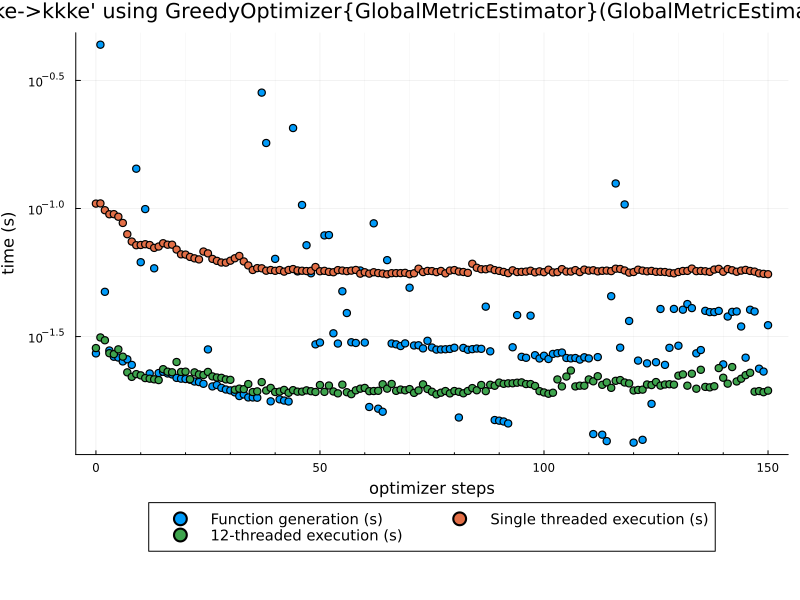

In [5]:
# plot data
using Plots
using StatsPlots

img = @df df scatter(
    :operations, 
    [:gen_func_t, :cpu_st_t, :cpu_mt_t], 
    label=["Function generation (s)" "Single threaded execution (s)" "$(Threads.nthreads())-threaded execution (s)"], 
    title="$(beautify_title(string(process))) using $optimizer ($(n_inputs) inputs)",
    linewidth=2,
    xlabel="optimizer steps",
    ylabel="time (s)",
    yscale=:log10,
    legend=:outerbottom,
    legendcolumns=2,
    legend_font_pointsize=10,
    minorgrid=true,
    size=(800, 600),
    fmt=:pdf
)

img

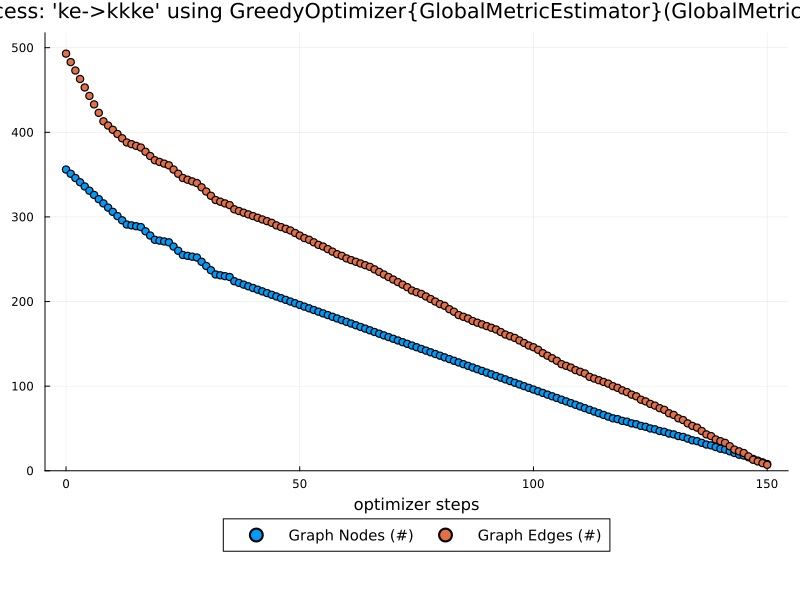

In [6]:
img = @df df scatter(
    :operations,
    [:graph_nodes, :graph_edges],
    label=["Graph Nodes (#)" "Graph Edges (#)"],
    title="$(beautify_title(string(process))) using $optimizer",
    linewidth=2,
    xlabel="optimizer steps",
    ylims=(0.0, 1.05 * maximum(df.graph_edges)),
    legend=:outerbottom,
    legendcolumns=2,
    legend_font_pointsize=10,
    fmt=:pdf,
    size=(800, 600)
)

img

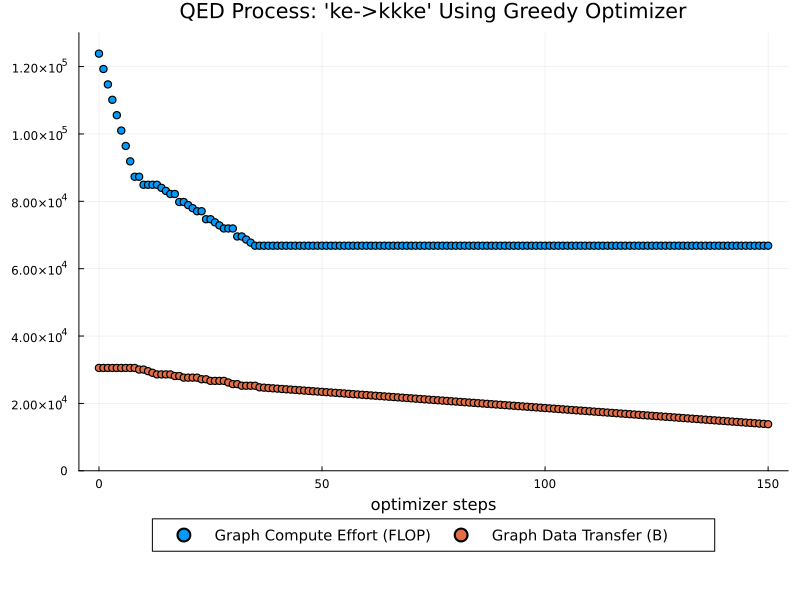

In [8]:
img = @df df scatter(
    :operations,
    [:graph_ce, :graph_dt],
    label=["Graph Compute Effort (FLOP)" "Graph Data Transfer (B)"],
    title="$(beautify_title(string(process))) Using Greedy Optimizer",
    linewidth=2,
    xlabel="optimizer steps",
    ylims=(0.0, 1.05 * maximum(df.graph_ce)),
    legend=:outerbottom,
    legendcolumns=2,
    legend_font_pointsize=10,
    fmt=:pdf,
    size=(800, 600)
)

img

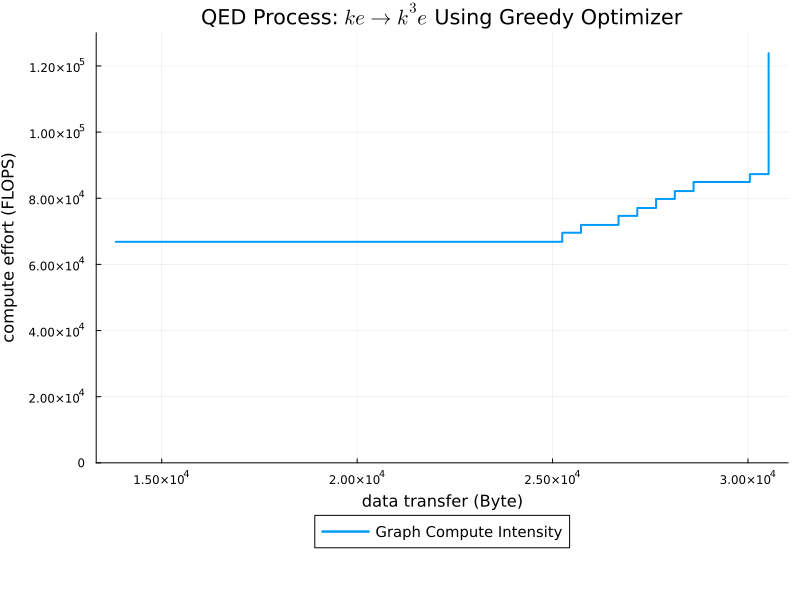

┌ Warning: n° of legend_column=2 is larger than n° of series=1
└ @ Plots /home/antonr/.julia/packages/Plots/sxUvK/src/backends/gr.jl:1235
┌ Warning: n° of legend_column=2 is larger than n° of series=1
└ @ Plots /home/antonr/.julia/packages/Plots/sxUvK/src/backends/gr.jl:1235


In [15]:
img = @df df plot(
    :graph_dt,
    :graph_ce,
    label="Graph Compute Intensity",
    title="$(beautify_title(string(process))) Using Greedy Optimizer",
    linewidth=2,
    xlabel="data transfer (Byte)",
    ylabel="compute effort (FLOPS)",
    ylims=(0.0, 1.05 * maximum(df.graph_ce)),
    legend=:outerbottom,
    legendcolumns=2,
    legend_font_pointsize=10,
    fmt=:pdf,
    size=(800, 600)
)

img